# Canny Edge Detector


1. Gaussian filter
2. Find the intensity gradient of the image

  a. Apply a pair of convolution masks

  ![](https://i.imgur.com/EiYaObX.png)

  b. Find the gradient strength and direction with:

  ![](https://i.imgur.com/U5FEiKe.png)

3. Non-maximum Suppression
4. Thresholding edges
5. Hysteresis: The final step. Canny does use two thresholds (upper and lower):
>If a pixel gradient is higher than the upper threshold, the pixel is accepted as an edge
If a pixel gradient value is below the lower threshold, then it is rejected.
If the pixel gradient is between the two thresholds, then it will be accepted only if it is connected to a pixel that is above the upper threshold.
Canny recommended a upper:lower ratio between 2:1 and 3:1.

[Canny Edge Detector](https://docs.opencv.org/master/da/d5c/tutorial_canny_detector.html)

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/電腦視覺作業1')

Mounted at /content/drive


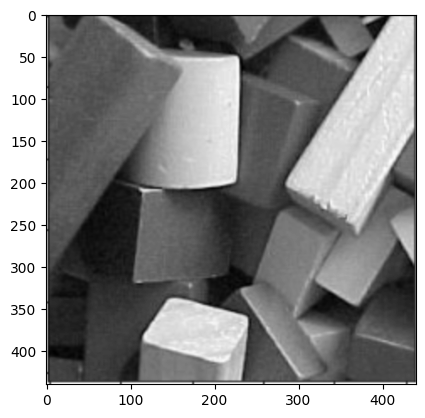

image.shape:  (440, 440)


In [ ]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

image = cv2.imread("blocks.jpg",0)
plt.imshow(image ,cmap='gray')
plt.show()
print('image.shape: ', image.shape)


## Step 1. Gaussian filter

original shape:  (440, 440)
gaussian shape:  (440, 440)


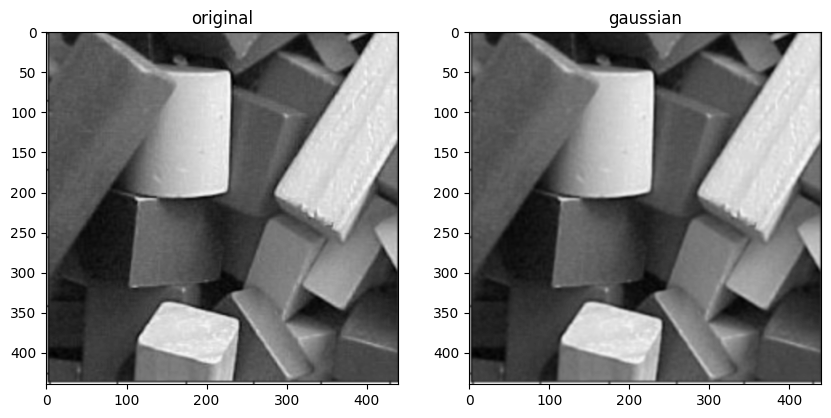

In [ ]:
# Canny 邊緣檢測
# 1. 噪聲過濾：使用高斯濾波器進行平滑處理，以減少噪聲的影響。
# 2. 計算梯度：找到圖像中的邊緣
# 3. 非極大值抑制：在梯度方向上，對圖像進行遍歷，將局部最大值（即邊緣）保留，其他像素值設為0。
# 4. 雙閾值檢測：通過設定兩個閾值，將非極大值中的強邊緣和弱邊緣區分開來。
# 5. 邊緣追蹤：根據強邊緣的位置，追踪和連接其周圍的弱邊緣，形成完整的邊緣。


def padding_img(img, k_size, style='edge'): # 對圖像進行填充
    # ------------ To do ------------- #
    height, width = img.shape

    res = np.zeros((height + k_size * 2, width + k_size * 2), dtype=np.uint8)
    res[k_size:k_size + height, k_size:k_size + width] = img

    # 填充上下邊
    res[0:k_size, k_size:k_size + width] = img[0, :]  # 上邊
    res[-k_size:, k_size:k_size + width] = img[-1, :]  # 下邊

    # 填充左右邊
    res[k_size:k_size + height, 0:k_size] = img[:, 0][:, np.newaxis]  # 左邊
    res[k_size:k_size + height, -k_size:] = img[:, -1][:, np.newaxis]  # 右邊

    # 填充四個角落
    res[0:k_size, 0:k_size] = img[0,0]  # 左上
    res[0:k_size, -k_size:] = img[0,-1]  # 右上
    res[-k_size:, 0:k_size] = img[-1,0]  # 左下
    res[-k_size:, -k_size:] = img[-1,-1]  # 右下

    return res
    # ---------------------------------- #

def gaussian_kernel(size):
    # ------------ To do ------------- #
    sigma = 0.3*((size-1)*0.5 - 1) + 0.8
    Gaussian=[]
    #各係數相加後總值
    total=0
    for i in range(0,size):
        Filter_list = []
        for j in range(0,size):
            #高斯函數公式
            center_idx = (size-1) / 2
            y_bias = i - center_idx
            x_bias = j - center_idx
            g = (1/(2*np.pi*sigma**2)) * np.exp(-(x_bias**2+y_bias**2)/(2*sigma**2))
            total += g
            Filter_list.append(g)
        Gaussian += [Filter_list]

    return np.array(Gaussian) / total
    # ---------------------------------- #

KernelSize = 3

# 拿HW1的convolution來用(改成處理灰階圖片版本)
def Convolution(image, Kernel):
    row, col = image.shape
    resx=np.zeros((row,col), dtype=np.float32)
    padimg = padding_img(image, (KernelSize-1)//2, style='edge') # padding style改成edge
    for x in range(row):
        for y in range(col):
            sum = 0
            for i in range(Kernel.shape[0]):
                for j in range(Kernel.shape[1]):
                    sum += padimg[x+i,y+j] * Kernel[i,j]
            resx[x,y] = sum
    resx = np.clip(resx, 0, 255).astype(np.uint8) # 將卷積結果得像素值限制在0到255間
    return resx

def Gaussian_Filter(KernelSize, image):
    Gaussian_Kernel = gaussian_kernel(KernelSize)
    # ------------ To do ------------- #
    return Convolution(image, Gaussian_Kernel)
    # ---------------------------------- #

# 印出 original shape,gaussian shape
# 輸出 original,gaussian 兩張圖
Gaussian_img = Gaussian_Filter(KernelSize, image)
print(f'original shape:  {image.shape}')
print(f'gaussian shape:  {Gaussian_img.shape}')
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title('original')
plt.imshow(image, cmap='gray')
plt.subplot(122)
plt.title('gaussian')
plt.imshow(Gaussian_img, cmap='gray')
plt.show()

## Step 2. Filter image with derivative of Gaussian
![](https://i.imgur.com/G4e6Z4n.png)

In [ ]:
def sobel(img, filtering_type):
    h, w = img.shape

    # Sobel filter kernels
    horizontal = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])  # Gx
    vertical = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])    # Gy

    Gx = np.zeros((h - 2, w - 2))
    Gy = np.zeros((h - 2, w - 2))

    # ------------ To do ------------- #
    # 計算水平和垂直方向的梯度
    for img_region, i, j in iterate_regions(img, 3):
        Gx[i,j] = np.sum(img_region * horizontal)
        Gy[i,j] = np.sum(img_region * vertical)

    # 計算梯度大小及角度
    output = np.sqrt(Gx**2 + Gy**2)
    angle = np.arctan2(Gy, Gx) * (180/np.pi)
    angle[angle < 0] += 360 # angle範圍0~360度

    # clip range to [0,255]
    Gx = np.clip(Gx, 0, 255)
    Gy = np.clip(Gy, 0, 255)
    output = np.clip(output, 0, 255)
    # ---------------------------------- #
    # 回傳梯度大小(output)和角度(angle)、Gx、Gy
    return Gx, Gy, output, angle

def iterate_regions(img, kernel_size):
    h, w = img.shape
    for i in range(h - kernel_size + 1):
        for j in range(w - kernel_size + 1):
            img_region = img[i:(i + kernel_size), j:(j + kernel_size)]
            yield img_region, i, j


gaussian shape:  (440, 440)
Horizontal Sobel filter shape:  (438, 438)
Vertical Sobel filter shape:  (438, 438)
Gradient amplitude shape:  (438, 438)


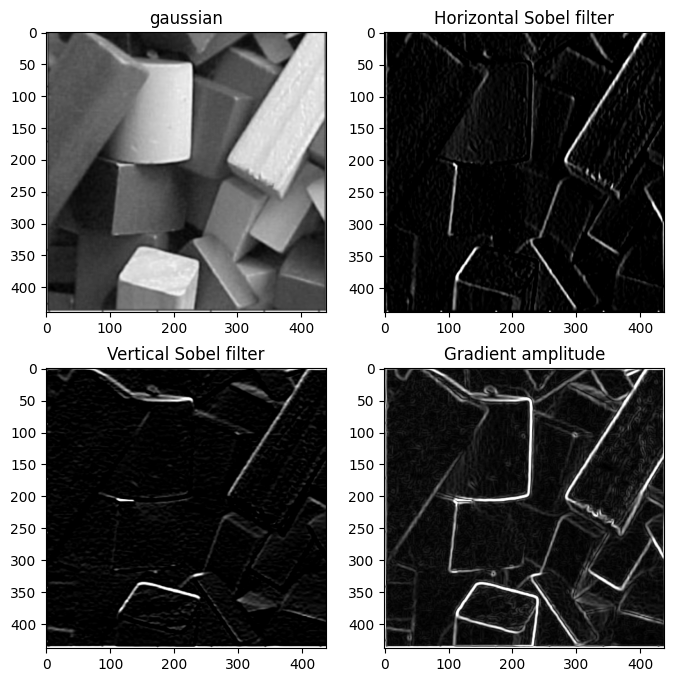

In [ ]:
# ------------ To do ------------- #
# 印出 gaussian shape,Horizontal Sobel filter shape,Vertical Sobel filter shape,Gradient amplitude shape
# 輸出四張圖
Gx, Gy, gradient, angle = sobel(Gaussian_img, filtering_type = 'sobel')

print(f'gaussian shape:  {Gaussian_img.shape}')
print(f'Horizontal Sobel filter shape:  {Gx.shape}')
print(f'Vertical Sobel filter shape:  {Gy.shape}')
print(f'Gradient amplitude shape:  {gradient.shape}')

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.title('gaussian')
plt.imshow(Gaussian_img, cmap='gray')
plt.subplot(222)
plt.title('Horizontal Sobel filter')
plt.imshow(Gx, cmap='gray')
plt.subplot(223)
plt.title('Vertical Sobel filter')
plt.imshow(Gy, cmap='gray')
plt.subplot(224)
plt.title('Gradient amplitude')
plt.imshow(gradient, cmap='gray')

## Step 3. Non-maximum Suppression
Non maximum suppression without interpolation requires us to divide the 3x3 grid of pixels into 8 sections. Ie. if the gradient direction falls in between the angle -22.5 and 22.5, then we use the pixels that fall between this angle (r and q) as the value to compare with pixel p, see image below.

![](https://i.imgur.com/55DLrWn.png)

In [ ]:
def non_maximum_suppression(gradient, angle):
    gradient_copy = gradient.copy()
    height, width = gradient.shape
    for i in range(1, height-1):
        for j in range(1, width-1):

             #將每個 pixel 依序當作中心 pixel 並由其梯度角度判斷該與哪個方向的相鄰 pixel 比較梯度大小
             #(ex.梯度方向為 -22.5° 到 22.5°皆視為0°，並與水平左右相鄰 pixel 比較)
             #若中心 pixel 比較後非最大值則中心 pixel 梯度值設為0(此 pixel 視為非邊緣)，比較後為最大值則不改變其梯度值
            # ------------ To do ------------- #
            # 跟左、右比
            if (0 <= angle[i,j] < 22.5 or 337.5 <= angle[i,j] < 360 or 157.5 <= angle[i,j] < 202.5):
                if (gradient[i,j] < gradient[i,j-1] or gradient[i,j] < gradient[i,j+1]):
                    gradient_copy[i,j] = 0
            # 跟左下、右上比
            if (22.5 <= angle[i,j] < 67.5 or 202.5 <= angle[i,j] < 247.5):
                if (gradient[i,j] < gradient[i+1,j-1] or gradient[i,j] < gradient[i-1,j+1]):
                    gradient_copy[i,j] = 0
            # 跟上、下比
            if (67.5 <= angle[i,j] < 112.5 or 247.5 <= angle[i,j] < 292.5):
                if (gradient[i,j] < gradient[i-1,j] or gradient[i,j] < gradient[i+1,j]):
                    gradient_copy[i,j] = 0
            # 跟左上、右下比
            if (112.5 <= angle[i,j] < 157.5 or 292.5 <= angle[i,j] < 337.5):
                if (gradient[i,j] < gradient[i-1,j-1] or gradient[i,j] < gradient[i+1,j+1]):
                    gradient_copy[i,j] = 0
            # ---------------------------------- #

    return gradient_copy

Gx, Gy, gradient, angle = sobel(Gaussian_img, 'magnitude')
After_non_maximum_supression = non_maximum_suppression(gradient,angle)
print(After_non_maximum_supression)

[[255.         255.         164.8393157  ... 255.         217.41205118
   56.0357029 ]
 [255.         255.           0.         ... 255.         255.
  216.37929661]
 [255.           0.           0.         ... 255.         255.
  255.        ]
 ...
 [255.         255.         255.         ...   0.           0.
  206.73654733]
 [255.         255.         255.         ... 255.         255.
  255.        ]
 [255.         255.         255.         ... 255.         255.
  255.        ]]


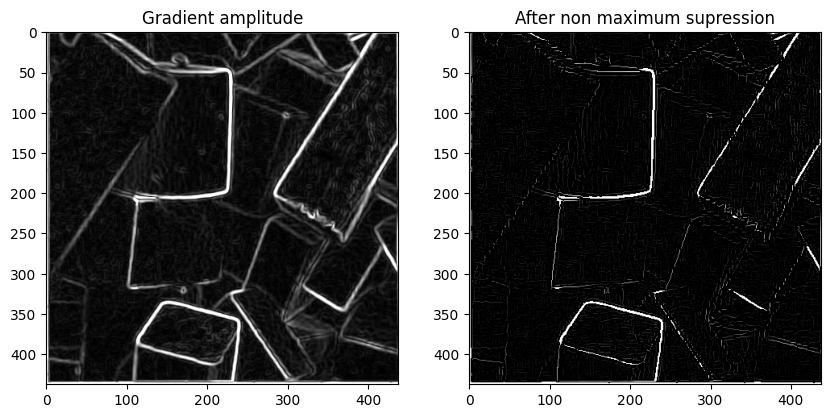

In [ ]:
# ------------ To do -------------
After_non_maximum_supression = np.clip(After_non_maximum_supression, 0, 255)
plt.figure(figsize = (10, 5))
plt.subplot(121)
plt.title('Gradient amplitude')
plt.imshow(gradient, cmap = 'gray')
plt.subplot(122)
plt.title('After non maximum supression')
plt.imshow(After_non_maximum_supression, cmap = 'gray')

## Step 4. Thresholding edges

In [ ]:
def seperate(img, minimum, maximum):
    # ------------ To do ------------- #
    img_copy = img.copy()
    height, width = img.shape
    for i in range(height):
        for j in range(width):
            if img[i,j] <= minimum: # 非邊緣
                img_copy[i,j] = 0
            elif minimum < img[i,j] <= maximum: # 弱邊緣
                img_copy[i,j] = 50
            elif img[i,j] > maximum: # 強邊緣
                img_copy[i,j] = 100

    return img_copy
     #避免直接修改輸入的圖像，創建一個圖像的副本
     #判斷圖像中的每個像素的梯度大小(分為強邊緣、弱邊緣及非邊緣並分別設值)
     #回傳處理後的圖像

    # ---------------------------------- #

thresholding = seperate(After_non_maximum_supression, minimum = 50, maximum = 100)

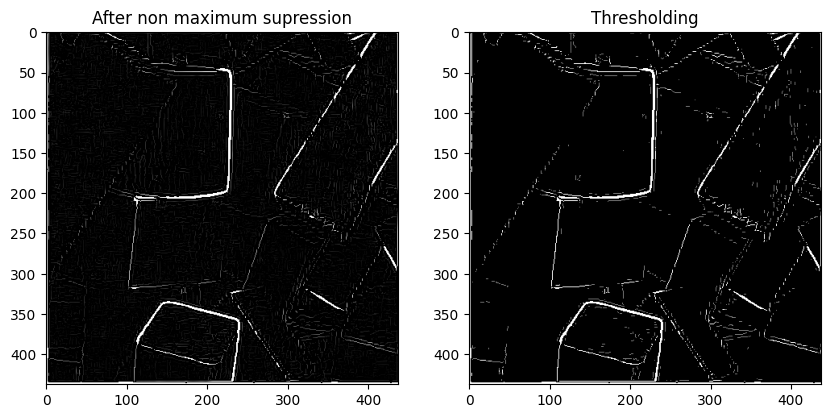

In [ ]:
# ------------ To do ------------- #
plt.figure(figsize = (10, 5))
plt.subplot(121)
plt.title('After non maximum supression')
plt.imshow(After_non_maximum_supression, cmap = 'gray')
plt.subplot(122)
plt.title('Thresholding')
plt.imshow(thresholding, cmap = 'gray')

## Step 5. Hysteresis

In [ ]:
def Connect(img, weak):
  # ------------ To do ------------- #
    img_copy = img.copy()
    height, width = img.shape
    for h in range(1, height-1):
        for w in range(1, width-1):
            if img[h,w] == weak:
                if (img[h-1:h+2, w-1:w+2] > weak).any(): # 若此區域中的最大值大於 weak，表示弱邊緣像素連接到周圍的強邊緣
                    img_copy[h,w] = 100 # 則該像素視為邊緣
                else: # 若此區域中的最大值不大於 weak
                    img_copy[h,w] = 0 # 則不保留此弱邊緣像素
    return img_copy # 回傳經過弱邊緣連接處理後的圖像
   # ---------------------------------- #

dst_img = Connect(thresholding, weak=50)


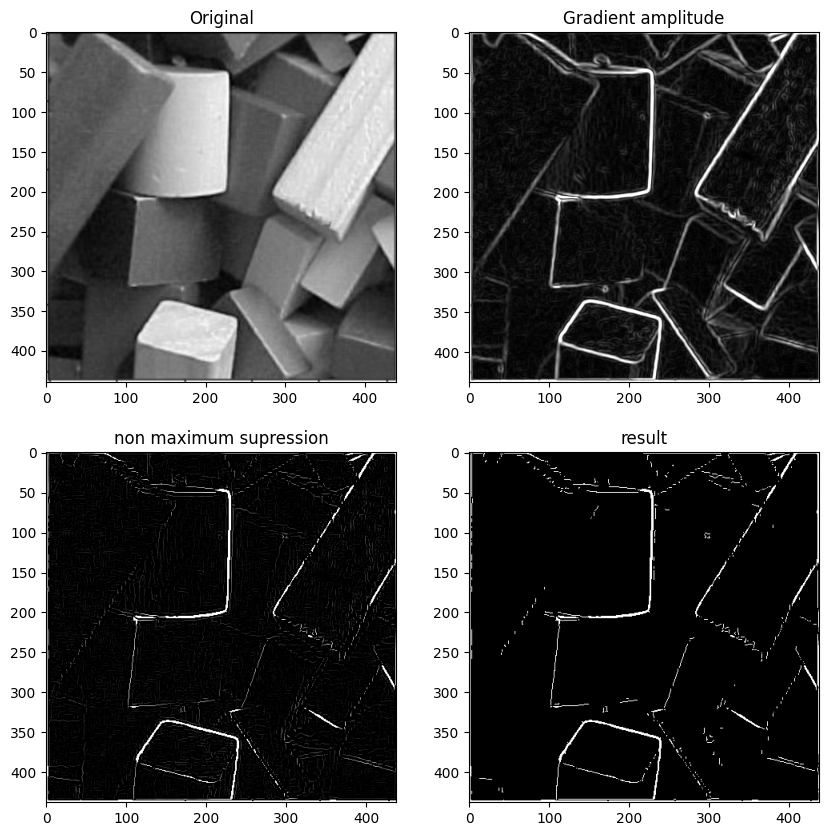

In [ ]:
# ------------ To do ------------- #
plt.figure(figsize = (10, 10))
plt.subplot(221)
plt.title('Original')
plt.imshow(image, cmap = 'gray')
plt.subplot(222)
plt.title('Gradient amplitude')
plt.imshow(gradient, cmap = 'gray')
plt.subplot(223)
plt.title('non maximum supression')
plt.imshow(After_non_maximum_supression, cmap = 'gray')
plt.subplot(224)
plt.title('result')
plt.imshow(dst_img, cmap = 'gray')
plt.show()

## Canny Edge OpenCV 套件


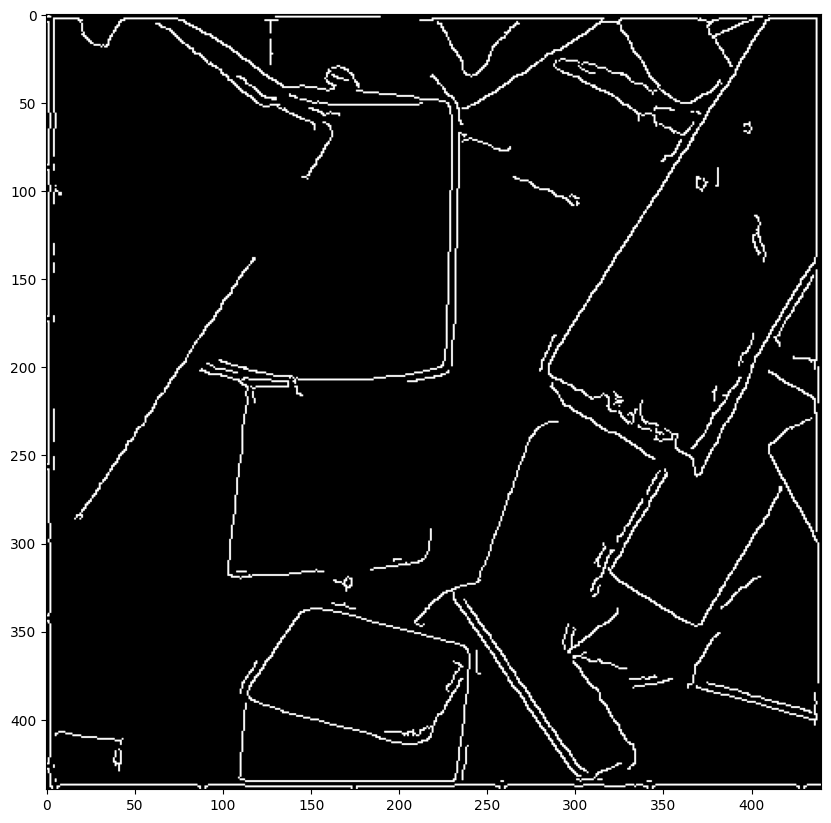

In [ ]:
low_threshold = 50
high_threshold = 100
kernel_size = 3
#這邊較低的threshold用於檢測圖像中明顯的邊緣，較高的threshold則將間斷的邊緣連接起來。
plt.figure(figsize=(10,18))
img2 = cv2.imread("blocks.jpg",0)
gray_blur = cv2.GaussianBlur(img2,(kernel_size, kernel_size),0)
edges = cv2.Canny(gray_blur, low_threshold, high_threshold)
plt.imshow(edges, cmap='Greys_r')
plt.show()

## 加分討論：為什麼和套件不一樣？

我覺得要做到一樣很難，我照著提示的步驟一步步做，做出來的結果也跟助教給的範例圖不一樣，到Gradient amplitude都還差不多，但到non maximum supression就差很多了QQ。
### 總之，我覺得可能導致與套件不一樣的原因有：
1. Gaussian filter：這裡我們是用3\*3的filter，但說不定套件是用5\*5或7\*7等等，不同size的filter處理圖片效果差異很大，而且這又是第一步，我覺得這是做出來跟套件不同的重要原因。
2. Gradient計算方法：我們是使用sobel filter來計算gradient方向、大小，但說不定套件是用別的filter算的，如果這樣的話就影響很大了。
3. Convolution方法：我覺得我做的convolution已經是有符合定義的，但可能因為一些datatype誤差，以及clip data的時間點，導致Convolution的結果有所不同。
4. 有沒有normalize：我的作法都是直接把gradient clip到[0,255]，但說不定套件是使用normalize把值等比例的縮放到[0,255]，這樣可能就會差很多。
5. Non-maximum Suppression：我把angle的範圍存成[0,360]，並分成8個方向來比對，感覺是已經有做到要求，但做出來跟助教範例差很多，所以我覺得這步驟可能有鬼，感覺這裡角度處理的方法可能也有影響。


# 加分題 : Dilation (膨脹) & Erosion (侵蝕)

## Dilation (膨脹)

In [ ]:
def Dilation(img, kernel):
  row, col = img.shape
  dilation_img = np.zeros((row, col))
  kernelsize = kernel.shape[0]
  padimg = padding_img(img, (kernelsize-1)//2)

  # -------- To do ------------- #


  # ------------------------------- #
  return dilation_img

res = Dilation(image, get_kernel('dilation', kernel_size = 3))

plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.title('original')
plt.imshow(image, cmap = 'gray')
plt.subplot(1,2,2)
plt.title('dilation')
plt.imshow(res, cmap = 'gray')
plt.show()

print('original shape: ', image.shape)
print('dilation shape: ', res.shape)

## Erosion (侵蝕)

In [ ]:
def Erosion(img, kernel):
  row, col = img.shape
  erosion_img = np.zeros((row, col))
  kernelsize = kernel.shape[0]
  img = padding_img(img, (kernelsize-1)//2)

  # -------- To do ------------- #

  # ------------------------------- #
  return erosion_img

res = Erosion(img, get_kernel('erosion', kernel_size = 3))

plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.title('original')
plt.imshow(img, cmap = 'gray')
plt.subplot(1,2,2)
plt.title('erosion')
plt.imshow(res, cmap = 'gray')
plt.show()

print('original shape: ', img.shape)
print('erosion shape: ', res.shape)